# Assignment 3: Generating "Human-Like" Pieces from a Given Corpus

## Part 1: Preprocessing - Parsing the dataset

Goal: Parse the abc music files to only get the elements related to the rhythm and pitch. We will use music21 to obtain, from each piece's abc file, a list of bars with each bar containing the beat onset on which a note appears, and the pitch of each corresponding note in midi number. Then, we will create a Dataframe of all the pieces encoded in list form, which we can split to use as a training set and a test set.

In [2]:
# !pip install music21
# !pip install textract
# !pip install networkx

import pandas as pd
import numpy as np
import random
import ast
import music21
import os
import textract
import pathlib
from collections import defaultdict
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Here are all the functions we defined for parsing

# Function that, from an abc file, gets the beat distribution and pitch distribution of every bar of the piece
# Returns an array (piece) of arrays (bars)
def extractBeatAndPitchArrays(path):

    # getting the parsable score
    sample = music21.converter.parse(path)
    part = sample.parts[0]
    notes = part.recurse().notes
    length_in_bars = int(sample.duration.quarterLength/sample.getTimeSignatures()[0].numerator) 
    # should be numerator*(denominator/4), but here denominator is already 4 since all pieces are in 3/4
    
    bars_beats = []
    bars_pitches = []

    # iteratively adding every beat of every bar. Each bar is a list and the piece is a list of bars i.e. a list of lists
    for i in range(0, length_in_bars):
        if part.measure(i) is not None:
            notes = part.measure(i).notes
            beats = []
            pitches = []
            for n in notes:
                beats.append(n.beat)
                pitches.append(n.pitch.midi)
                    
        bars_beats.append(beats)
        bars_pitches.append(pitches)
        i += 1

    return bars_beats, bars_pitches

# Function that maps the beat distribution of a bar to a series of numbers between 1 and 12 (position of each sixteenth-note in the bar)
def map_beats(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for x in bar:
            bar_mapped.append(int(4*(x-1)+1))
        notes_mapped.append(bar_mapped)
    return notes_mapped

# Function that maps a series of numbers between 1 and 12 (position of each sixteenth-note in the bar) to a music21 beat distribution
def map_beats_reverse(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for y in bar:
            bar_mapped.append((y+3)/4)
        notes_mapped.append(bar_mapped)
    return notes_mapped

In [10]:
# Parsing the dataset with the above function

data_parse = pd.DataFrame(columns=['piece', 'beats', 'pitches', 'beat_pitch'])

directory = './abc'

pieces = 0 # check every piece in the directory (599) is encoded

for name in os.listdir(directory):
    pieces += 1
    path = directory + '/' + name 
    bars_beats = []
    bars_pitches = []
    try:
        bars_beats, bars_pitches = extractBeatAndPitchArrays(path)
    except:
        bars_beats = []
        bars_pitches = []

    if ((bars_beats != []) & (bars_pitches != [])): # not adding unparsed pieces to dataframe
        data_parse.loc[len(data_parse)] = [path, bars_beats, bars_pitches, []]

# map the beats to integers and make tuples
for _, d in data_parse.iterrows():
    d['beats'] = map_beats(d['beats'])

    notes = d['beats']
    pitches = d['pitches']

    tuples_note_pitch = []
    for j in range(len(notes)):
        bar_j = []
        for k in range(len(notes[j])):
            bar_j.append((notes[j][k], pitches[j][k]))
        tuples_note_pitch.append(bar_j)
    d['beat_pitch'] = tuples_note_pitch

print("Done")

print(f"{pieces} pieces were analysed.")    

print(f"{len(data_parse)} pieces were correctly parsed.")

Done
599 pieces were analysed.
484 pieces were correctly parsed.


In [11]:
data_parse.head()

,piece,beats,pitches,beat_pitch
0,./abc/1b651a94a8f8680da3cef1e60705194d.abc,"[[1, 3, 5, 6, 7, 8, 9, 11], [1, 3, 5, 6, 7, 8,...","[[69, 76, 81, 83, 81, 79, 77, 74], [74, 76, 79...","[[(1, 69), (3, 76), (5, 81), (6, 83), (7, 81),..."
1,./abc/3679c385a618c89f00d159f418022b39.abc,"[[1, 3, 4, 5, 7, 8, 9, 11], [1, 4, 5, 6, 7, 8,...","[[76, 76, 81, 76, 76, 77, 76, 74], [72, 71, 69...","[[(1, 76), (3, 76), (4, 81), (5, 76), (7, 76),..."
2,./abc/60ae81952628613e03d563b0dae8bbc2.abc,"[[1, 4, 5, 7, 9, 10, 11, 12], [1, 3, 5, 9, 11]]","[[62, 67, 71, 74, 72, 71, 72, 69], [67, 71, 62...","[[(1, 62), (4, 67), (5, 71), (7, 74), (9, 72),..."
3,./abc/6a7d307d1f0712090e4043a6b4637efa.abc,"[[1, 5, 9], [1, 1, 3, 4, 5, 7, 9, 11], [1, 4, ...","[[64, 69, 71], [71, 72, 71, 72, 74, 72, 71, 69...","[[(1, 64), (5, 69), (9, 71)], [(1, 71), (1, 72..."
4,./abc/8c6965e3c831e8cb769e578423c12d1e.abc,"[[1, 5, 7, 8, 9], [1, 3, 4, 5, 6, 7, 8, 9, 10,...","[[69, 67, 66, 67, 69], [69, 71, 73, 74, 73, 74...","[[(1, 69), (5, 67), (7, 66), (8, 67), (9, 69)]..."


In [28]:
# Testing the function mappings
example_notes = data_parse[data_parse['piece'] == './abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_no_10_d81ffb.abc']['beats'].tolist()[0]
# when we retrieve a specific piece and convert to list it wraps the piece's array in another array for some reason, hence the [0]
# but when doing iterrows we don't have that problem
print("Integer mapping:", example_notes)
map_onset = map_beats_reverse(example_notes)
print("Beat onset mapping:", map_onset)
print("Back to integer mapping:", map_beats(map_onset))

print("Pitches", data_parse[data_parse['piece'] == './abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_no_10_d81ffb.abc']['pitches'].tolist()[0])

Integer mapping: [[1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, 3, 4, 5, 7, 9, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5, 9], [1, 3, 5, 7, 9], [1, 3, 4, 5, 7, 8, 9], [1, 3, 5, 7, 8, 9], [1, 3, 4, 5, 7, 8, 9], [1, 3, 4, 5, 7, 8, 9, 11], [1, 2, 3, 4, 5, 9]]
Beat onset mapping: [[1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0], [1.0, 1.0, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0], [1.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 3.0], [1.0, 1.5, 2.0, 2.5, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 3.0]]
Back to integer mapping: [[1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, 3, 4, 5, 7, 9, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

In [15]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
# set random seed for reproducibility
x_train, x_test = train_test_split(data_parse, random_state=42) # split 75% train 25% test

print(len(x_train))
print(len(x_test))

363
121


In [28]:
# Writing train and test to csv
x_train.to_csv("train.csv", index=False)
x_test.to_csv("test.csv", index=False)

## Part 2: The Random Model

**Goal:** generate random 8-bar melodies (rhythm + pitch). The only constraints are the following: 
- the minimal note duration is a sixteenth note.
- all pitches are between C4 and C5

In [4]:
import random

random.seed(1113)

In [5]:
# function to fill a bar with random notes
def random_bar():
    # first = True
    first = False
    # first decide how many notes are in the bar
    # (the tempo is always 3/4)
    bar = []
    for i in range(11):
        # decide if a note is played
        if first:
            bar.append(1.0)
            first = False
        elif random.random() < 0.5:
            # if yes, decide which note
            bar.append((i/4)+1)
        # check that the bar is not empty
    if len(bar) == 0:
        bar = random_bar()
    return bar

# create a scale with all the notes from C4 to C5
sc = music21.scale.MajorScale('C4')
# get all the pitches from the scale
pitch_collection = sc.getPitches('C4', 'C5')
print(f"pitch_collection contains {len(pitch_collection)} pitches.")
print(pitch_collection)

# create list with pitches for the bar
def create_pitches(size, pitch_collection= pitch_collection):
    list_p = []
    for i in range(size):
        # append a random pitch from the scale
        list_p.append(random.choice(pitch_collection))
    return list_p

# create random song
def create_random_song():
    # make a list with 8 lists inside
    random_song = [[] for j in range(8)]
    random_pitches = [[] for j in range(8)]
    # for each list in random_song fill it with random notes
    for i in range(8):
        random_song[i] = random_bar()
        random_pitches[i] = create_pitches(len(random_song[i]))
    return random_song, random_pitches

# function to convert from beats into durations
def convert_to_duration(random_song_list):

    last = 3.0
    # read the list backwards
    random_song_list.reverse()
    # create a list with the duration of each note
    duration_list = []
    for bar in random_song_list:
        # reverse the inner list
        bar.reverse()
        for note in bar:
            duration_list.append(last - note)
            last = note
        last += 3.0
    # reverse the list again
    duration_list.reverse()
    # return original order to original song aswell
    random_song_list.reverse()
    for bar in random_song_list:
        bar.reverse()
    return duration_list

# Function that creates a list of notes from pitches
def elongate_pitch_list(pitch_list):
    new_list = []
    for bar in pitch_list:
        for note in bar:
            new_list.append(note)
    return new_list

# translate the music21 pitches to midi numbers
def translate_pitches(pitches):
    midi_pitches = []
    for bar in pitches:
        bar_midi = []
        for pitch in bar:
            bar_midi.append(pitch.midi)
        midi_pitches.append(bar_midi)
    return midi_pitches

# convert durations and pitches to a midi stream
def convert_to_stream(duration_list, pitch_list):
    pitch_list = elongate_pitch_list(pitch_list)
    # create an empty stream
    stream = music21.stream.Stream()
    # define the tempo as 3/4
    stream.append(music21.meter.TimeSignature('3/4'))
    # create note
    # assign the pitch of the random_pitches list
    # assign duration (quarter)
    # append the note into empty stream
    count = 0
    for duration in duration_list:
        note = music21.note.Note(pitch=pitch_list[count], quarterLength=duration)
        stream.append(note)
        count += 1
    return stream


pitch_collection contains 8 pitches.
[<music21.pitch.Pitch C4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch C5>]


In [10]:
# example
random_song, random_pitches = create_random_song()
print('Random song: ', random_song)
print('Random pitches: ', random_pitches)
duration_list = convert_to_duration(random_song)
print('Duration list example: ', duration_list)

# print with map_beats conversion (map_beats function from Part 1) and without
print('Random sequence represented by integers:\n', map_beats(random_song))
print('Random sequence represented by beat onsets:\n', map_beats_reverse(map_beats(random_song)))
print('Random song with pitches as midi numbers: ', translate_pitches(random_pitches))

# midi conversion
stream = convert_to_stream(duration_list, random_pitches)
stream.show('midi')

Random song:  [[1.75, 2.0, 2.25, 2.75, 3.25, 3.5], [1.0, 1.25, 1.5, 2.25, 2.75, 3.5], [2.0, 2.25, 2.75, 3.0, 3.25, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75], [1.0, 1.5, 1.75, 2.25, 2.75, 3.25, 3.5], [1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.5], [1.0, 2.25, 3.25, 3.5], [1.0, 1.5, 2.0]]
Random pitches:  [[<music21.pitch.Pitch A4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch E4>], [<music21.pitch.Pitch E4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch A4>], [<music21.pitch.Pitch A4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch C4>, <music21.pitch.Pitch B4>], [<music21.pitch.Pitch C5>, <music21.pitch.Pitch C4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch B4>], [<m

In [21]:
# produce a dataframe size 500 samples and save it as csv

# os.mkdir("./random_rhythms") # this was run once, no need to run it again

# produce a dataframe size 500 samples and save it as csv
def produce_dataframe():
    df = pd.DataFrame(columns=['id', 'beats', 'pitches', 'tuple_beat_and_pitch', 'midi'])
    for i in range(500):
        random_song, random_pitches = create_random_song()
        # write stream to midi file
        stream = convert_to_stream(convert_to_duration(random_song),random_pitches)
        # save midi in the random_midis folder
        file_midi = f'random_midis/random_song_{i}.mid'
        stream.write('midi', file_midi)
        notes = map_beats(random_song)
        pitches = translate_pitches(random_pitches)
        tuples_note_pitch = []
        for j in range(len(notes)):
            bar_j = []
            for k in range(len(notes[j])):
                bar_j.append((notes[j][k], pitches[j][k]))
            tuples_note_pitch.append(bar_j)
        df.loc[len(df)] = [i, notes, pitches, tuples_note_pitch, file_midi]
    df.to_csv('random_songs.csv', index=False)
    return df

# our data
df = produce_dataframe()
print(f"{len(df)} random songs generated.")

# save
df.to_csv('random_songs.csv', index=False)

# display
df.head()

500 random songs generated.


,id,beats,pitches,tuple_beat_and_pitch,midi
0,0,"[[1, 3, 4, 6], [2, 3, 4, 5, 7, 10], [1, 4, 5, ...","[[62, 67, 65, 65], [72, 65, 62, 60, 71, 60], [...","[[(1, 62), (3, 67), (4, 65), (6, 65)], [(2, 72...",random_midis/random_song_0.mid
1,1,"[[2, 3, 4, 5, 6, 8, 9, 11], [2, 3, 4, 5, 6, 10...","[[67, 72, 60, 69, 64, 62, 62, 60], [67, 71, 67...","[[(2, 67), (3, 72), (4, 60), (5, 69), (6, 64),...",random_midis/random_song_1.mid
2,2,"[[1, 2, 3, 4, 6, 7, 8], [1, 3, 5, 6, 7, 9, 11]...","[[67, 69, 60, 72, 72, 72, 60], [65, 64, 69, 71...","[[(1, 67), (2, 69), (3, 60), (4, 72), (6, 72),...",random_midis/random_song_2.mid
3,3,"[[1, 3, 4, 5, 6, 8, 9, 10, 11], [3, 4, 6, 7, 9...","[[65, 60, 67, 65, 69, 72, 69, 71, 65], [62, 62...","[[(1, 65), (3, 60), (4, 67), (5, 65), (6, 69),...",random_midis/random_song_3.mid
4,4,"[[4, 5, 6, 8, 9], [1, 2, 4, 6, 8, 10, 11], [1,...","[[69, 60, 64, 65, 72], [67, 60, 62, 62, 64, 64...","[[(4, 69), (5, 60), (6, 64), (8, 65), (9, 72)]...",random_midis/random_song_4.mid


In [22]:
# Testing the tuple format
print(df[['tuple_beat_and_pitch']])

                                  tuple_beat_and_pitch
0    [[(1, 62), (3, 67), (4, 65), (6, 65)], [(2, 72...
1    [[(2, 67), (3, 72), (4, 60), (5, 69), (6, 64),...
2    [[(1, 67), (2, 69), (3, 60), (4, 72), (6, 72),...
3    [[(1, 65), (3, 60), (4, 67), (5, 65), (6, 69),...
4    [[(4, 69), (5, 60), (6, 64), (8, 65), (9, 72)]...
..                                                 ...
495  [[(1, 67), (3, 62), (4, 69), (8, 64), (9, 64),...
496  [[(3, 69), (4, 60), (6, 72), (8, 69), (9, 72),...
497  [[(3, 72), (4, 62), (5, 60), (7, 62), (10, 62)...
498  [[(2, 72), (5, 67), (7, 72), (8, 67), (9, 67)]...
499  [[(2, 62), (3, 64), (4, 69), (5, 72), (6, 71),...

[500 rows x 1 columns]


## Part 3: The Generation Model

**Goal:** generate "human-like" 8-bar melodies in the style of Slängpolska. We will use a bigram-based Markov chain model, trained on 75% of the dataset as per the train-test split done in part 1.

In [147]:
np.random.seed(401)

data = pd.read_csv('train.csv')
data.head()

,piece,beats,pitches,beat_pitch
0,./abc/_Polonäs_sexdregasamlingen_del_2_nr_43_9...,"[[1, 5, 7, 9, 11], [1, 3, 5, 7, 9, 11], [1, 5,...","[[74, 69, 67, 66, 64], [62, 79, 78, 76, 78, 76...","[[(1, 74), (5, 69), (7, 67), (9, 66), (11, 64)..."
1,./abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_n...,"[[1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, ...","[[67, 79, 79, 78, 79, 76], [76, 78, 79, 76, 74...","[[(1, 67), (3, 79), (5, 79), (7, 78), (9, 79),..."
2,./abc/Polska_efter_Anders_Gustaf_Andersson_0ac...,"[[1, 3, 5, 7, 9, 11], [1, 3, 4, 5, 9], [1, 1, ...","[[81, 76, 77, 76, 77, 79], [81, 77, 81, 79, 76...","[[(1, 81), (3, 76), (5, 77), (7, 76), (9, 77),..."
3,./abc/Polonäs_9c99ae.abc,"[[1, 2, 3, 4, 5, 7, 9, 10, 11, 12], [1, 4, 5, ...","[[74, 72, 70, 69, 67, 62, 60, 58, 57, 55], [67...","[[(1, 74), (2, 72), (3, 70), (4, 69), (5, 67),..."
4,./abc/_Polonäs_sexdregasamlingen_del_2_nr_76_5...,"[[1, 3, 4, 5, 7, 9], [1, 3, 4, 5, 7, 8, 9], [1...","[[79, 78, 76, 74, 72, 71], [67, 67, 71, 69, 69...","[[(1, 79), (3, 78), (4, 76), (5, 74), (7, 72),..."


In [148]:
import ast
# change the note column to list
data['beats'] = data['beats'].apply(ast.literal_eval)
data['pitches'] = data['pitches'].apply(ast.literal_eval)
data['beat_pitch'] = data['beat_pitch'].apply(ast.literal_eval)

In [149]:
from collections import defaultdict
from collections import Counter

# get the bigram of the music data
bigram = []
bigram_freq = defaultdict(int)

# get the bigram of each song
for i in range(len(data)):
    for bar in data.loc[i,'beat_pitch']:
        bigram.extend(zip(bar, bar[1:]))
    
# get the frequency of every bigram
bigram_freq = dict(Counter(bigram))
print("Frequency of every bigram:", len(bigram_freq))

# remove the identical bigram or bigram with wrong direction
wrong_bigrams = []
for key in bigram_freq:
    if key[0][0] >= key[1][0] or key[1][0]>12:
        wrong_bigrams.append(key)
for key in wrong_bigrams:
    del bigram_freq[key]
print("Frequency of correct bigrams:", len(bigram_freq))

Frequency of every bigram: 3956
Frequency of correct bigrams: 3854


In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

position_pitch_freq = defaultdict(int)

for beat_pitch in data['beat_pitch']:
    for bar in beat_pitch:
        for (pos, pitch) in bar:
            if pos <13:
                position_pitch_freq[(pos,pitch)] += 1

# Convert the defaultdict to a DataFrame
df = pd.DataFrame.from_dict(position_pitch_freq, orient='index')

# Reset the index and rename the columns
df = df.reset_index()
df.columns = ['Position_Pitch', 'Frequency']

# Create separate columns for Position and Pitch
df[['Position', 'Pitch']] = pd.DataFrame(df['Position_Pitch'].tolist(), index=df.index)
df = df.drop('Position_Pitch', axis=1)

# Pivot the DataFrame to create a multi-index with Position and Pitch
df_pivot = df.pivot_table(index='Pitch', columns='Position', values='Frequency', fill_value=0)

# Sort the DataFrame by the index (Pitch) in ascending order
df_pivot = df_pivot.sort_index(ascending=False)

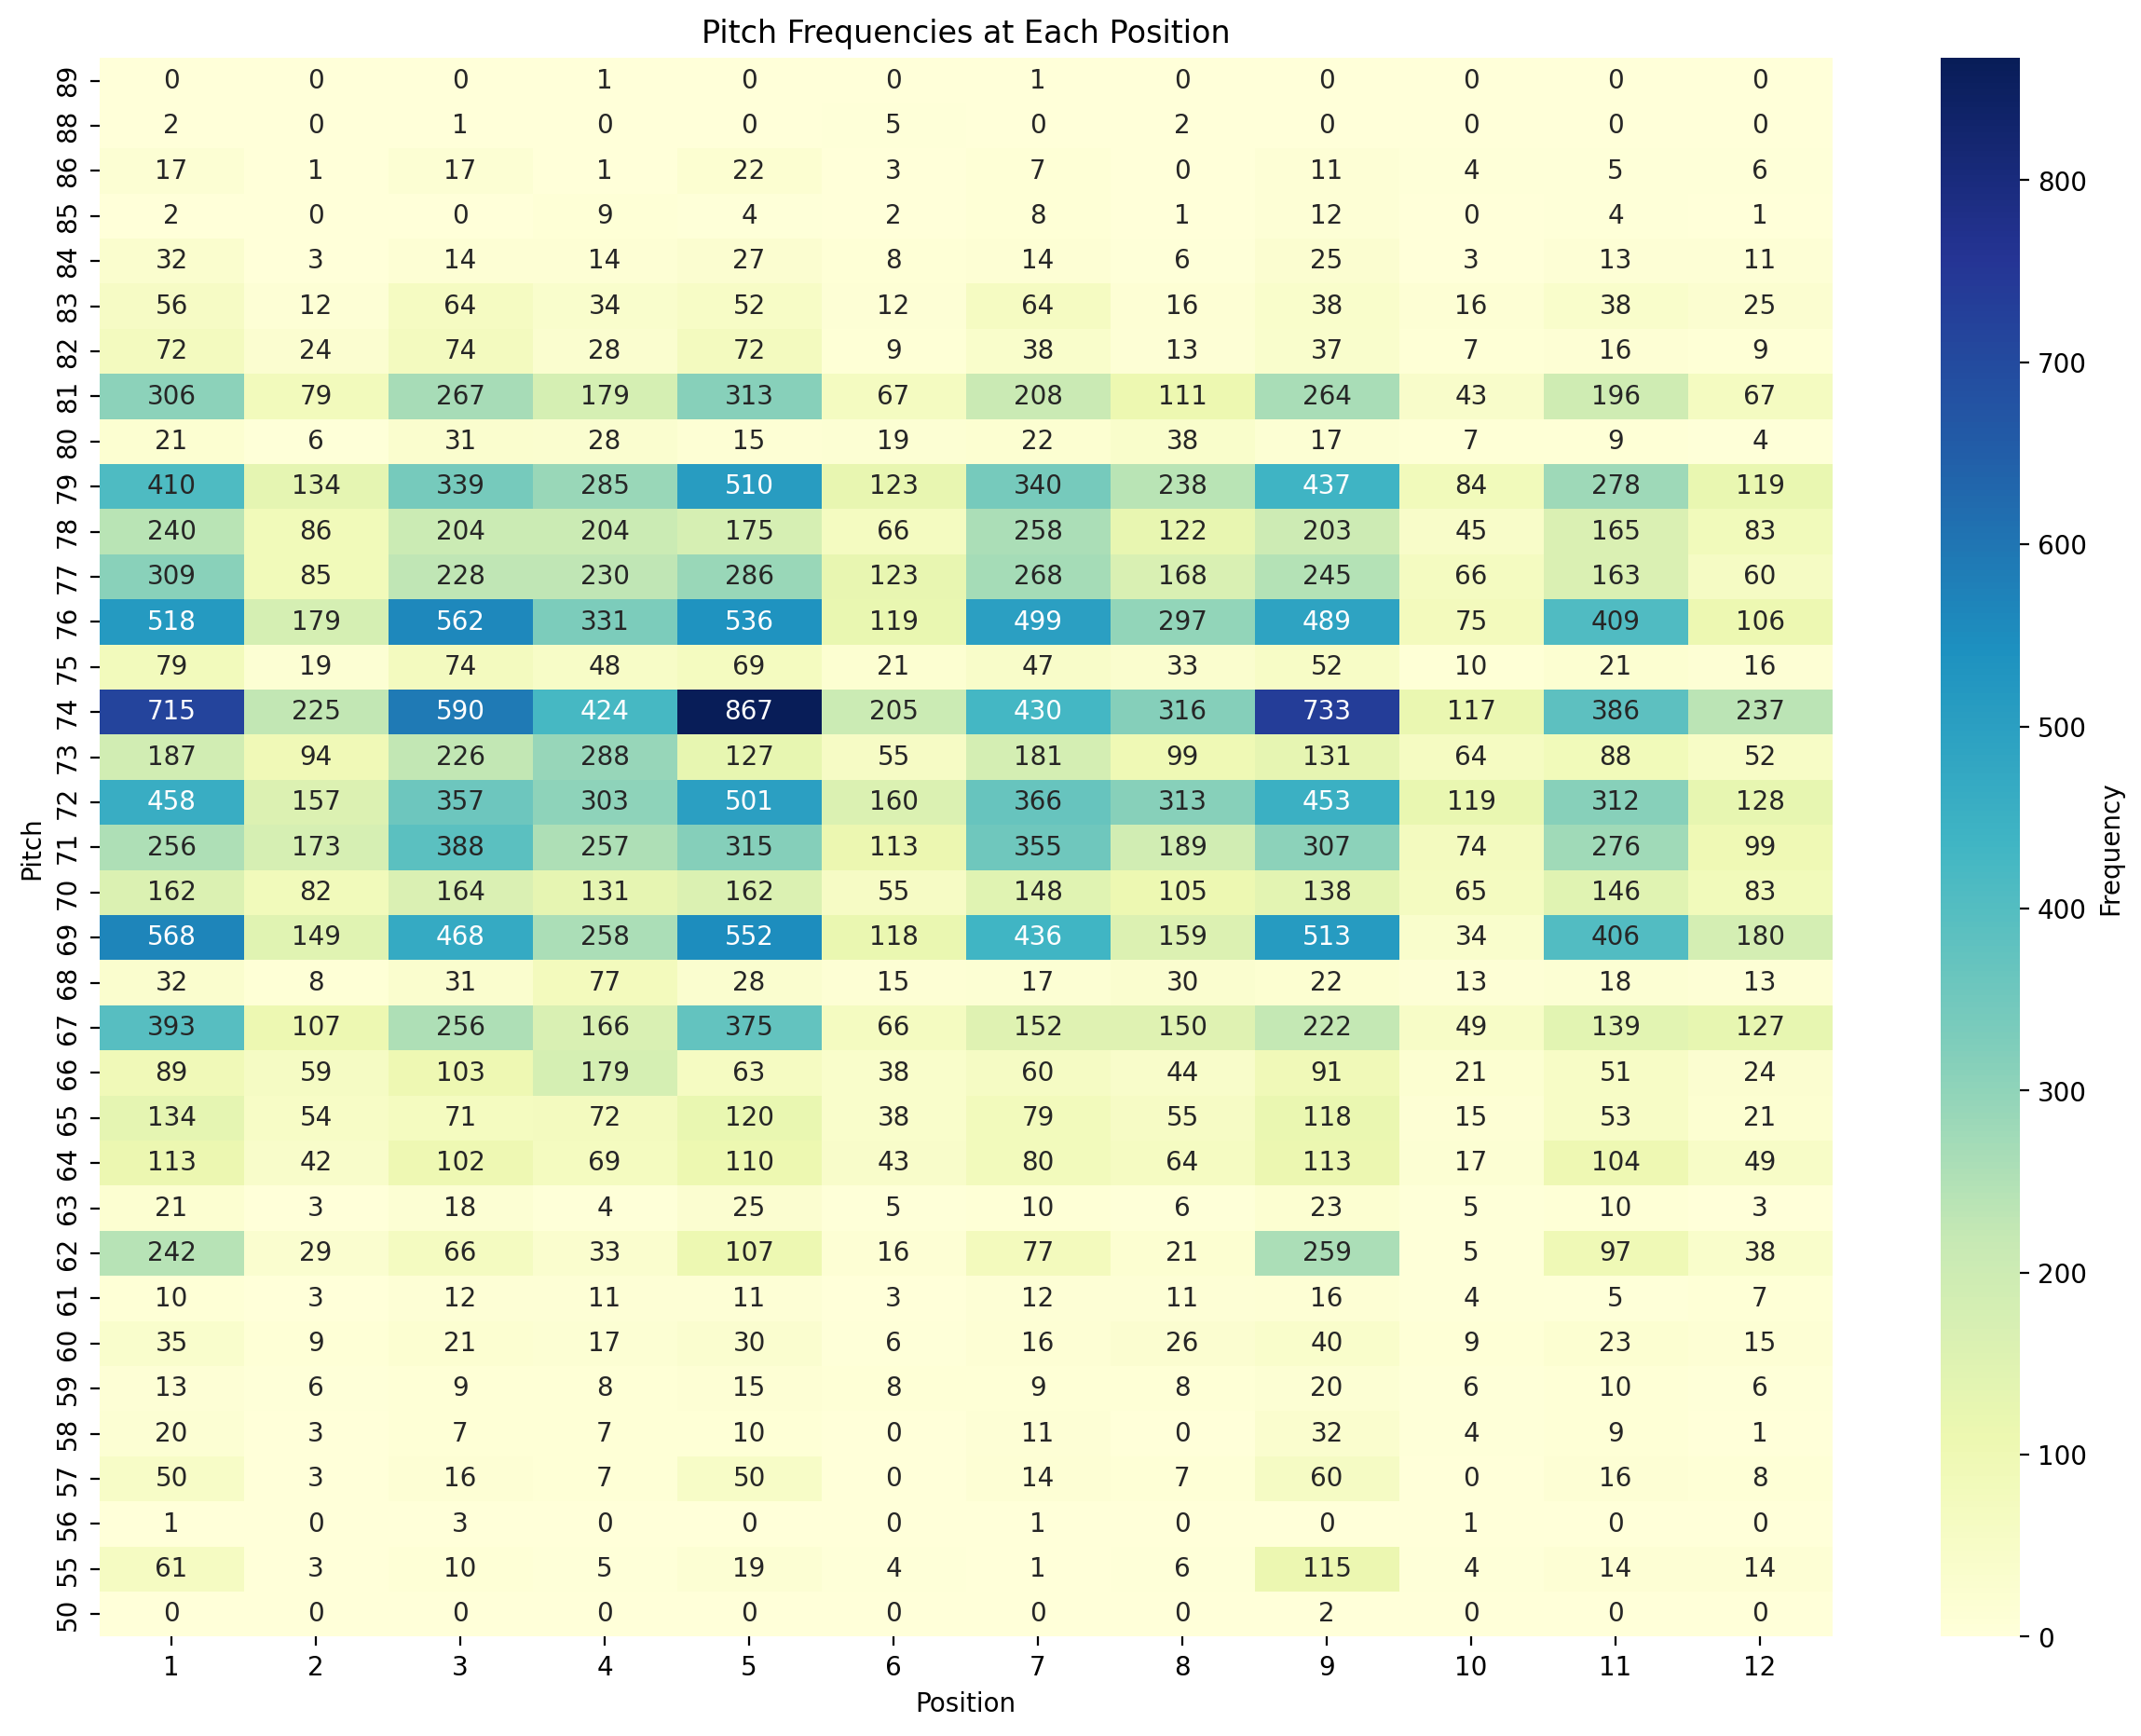

In [151]:
plt.figure(figsize=(15, 11))
sns.heatmap(df_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.xlabel("Position")
plt.ylabel("Pitch")
plt.title("Pitch Frequencies at Each Position")
plt.savefig('pitch_frequency.png')
plt.show()

In [152]:
# the generation model

# use the current position to predict the next position
def predict_next_state(bigram_freq, current_state):
    """
    predict the next state based on the bigram frequency
    """
    # get the possible next states
    possible_next_states = [k[1] for k, v in bigram_freq.items() if k[0] == current_state]
    # get the frequency of each possible next state
    freq = [v for k, v in bigram_freq.items() if k[0] == current_state]
    # normalize the frequency
    freq = np.array(freq) / np.sum(freq)
    # predict the next state
    next_state = random.choices(possible_next_states, weights=freq,k=1)[0]
    return next_state

# get the cosine similarity between two bars
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# change the position list to a vector of length 12
def seq_to_vec(seq):
    vec = [0] * 12
    for tup in seq:
        vec[tup[0]-1] = tup[1]
    return vec

# given the start position, generate a bar
def generate_a_bar(bigram_freq, start_state):
    """
    generate a bar based on the bigram frequency
    """
    bar = [start_state]
    while True:
        next_state = predict_next_state(bigram_freq, bar[-1])
        bar.append(next_state)
        # stop when the next state is 12 or the bar is longer than 4 and the next state is larger than 9 at the probability of 0.6
        if next_state[0] == 12 or (len(bar) >= 4 and next_state[0] >= 9 and np.random.random() > 0.6):
            break
    return bar

# generate a sequence of bars
def generate_sequence(bigram_freq, start_state, num_bars, similarity_threshold=0.5):
    """
    generate a sequence based on the bigram frequency
    """
    sequence = [generate_a_bar(bigram_freq, start_state)]
    while len(sequence) < num_bars:
        bar = generate_a_bar(bigram_freq, start_state)
        # compare the similarity between the last bar in the sequence and the new bar
        vec1 = seq_to_vec(sequence[-1])
        vec2 = seq_to_vec(bar)
        similarity = cosine_similarity(vec1, vec2)

        if similarity >= similarity_threshold:
            sequence.append(bar)

    return sequence

In [153]:
# example: generating one sequence/song based on the bigram frequency
sequence = generate_sequence(bigram_freq, start_state=(1,72),num_bars=8,similarity_threshold=0.85)
print(sequence)

[[(1, 72), (3, 76), (4, 77), (5, 74), (7, 72), (8, 71), (9, 69)], [(1, 72), (2, 69), (3, 71), (4, 73), (5, 73), (7, 76), (8, 77), (9, 76), (10, 74)], [(1, 72), (2, 69), (3, 65), (4, 68), (5, 68), (7, 69), (8, 67), (9, 69), (12, 66)], [(1, 72), (3, 72), (4, 74), (5, 70), (7, 69), (8, 72), (9, 74)], [(1, 72), (2, 71), (3, 74), (4, 77), (5, 74), (7, 72), (8, 70), (9, 69), (11, 72), (12, 55)], [(1, 72), (4, 82), (5, 81), (7, 82), (8, 79), (9, 78), (11, 74), (12, 78)], [(1, 72), (3, 71), (5, 72), (7, 74), (8, 72), (9, 74), (11, 72), (12, 74)], [(1, 72), (3, 71), (4, 55), (5, 71), (7, 80), (9, 81), (11, 79), (12, 76)]]


In [154]:
# calculate the most common start state
start_states = []
for i in range(len(data)):
    for bar in data.loc[i,'beat_pitch']:
        try:
            start_states.append(bar[0])
        except:
            pass
start_states = dict(Counter(start_states))
print(len(start_states))

42


In [155]:
# Convert list of bars of midi numbers to music21 pitches
def convert_midinum_to_pitch(midinums):
    pitch_list = []
    for i in range(len(midinums)):
        bar_i = []
        for j in range(len(midinums[i])):
            bar_i.append(music21.pitch.Pitch(midinums[i][j]))
        pitch_list.append(bar_i)
    return pitch_list

In [156]:
# generate 500 sequences based on the most common start state
sequences = pd.DataFrame(columns=['beat','pitch','beat_pitch', 'midi'])
i = 0
while i < 500:
    try:
        # randomly choose a start state
        start_state = random.choices(list(start_states.keys()), weights=list(start_states.values()),k=1)[0]
        sequence = generate_sequence(bigram_freq, start_state=start_state,num_bars=8,similarity_threshold=0.85)
        beats = []
        pitches = []
        for bar in sequence:
            beats.append([beat for (beat, pitch) in bar])
            pitches.append([pitch for (beat, pitch) in bar])

        # creating the midi
        beats_for_midi = map_beats_reverse(beats)
        print(beats_for_midi)
        pitches_for_midi = convert_midinum_to_pitch(pitches)
        print(pitches_for_midi)
        break
        if (i==0):
            print(beats_for_midi)
            print(pitches_for_midi)
        stream = convert_to_stream(convert_to_duration(beats_for_midi), pitches_for_midi)
        # save midi in the markov_midis folder
        file_midi = f'markov_midis/markov_song{i}.mid'
        stream.write('midi', file_midi)

        sequences.loc[len(sequences)] = [beats, pitches, sequence, stream]
    except:
        i -= 1

    # creating the midi
    beats_for_midi = map_beats_reverse(beats)
    pitches_for_midi = convert_midinum_to_pitch(pitches)
    stream = convert_to_stream(convert_to_duration(beats_for_midi), pitches_for_midi)
    # save midi in the markov_midis folder
    file_midi = f'markov_midis/markov_song{i}.mid'
    stream.write('midi', file_midi)

    sequences.loc[len(sequences)] = [beats, pitches, sequence, stream]
    i += 1
sequences.to_csv('markov_songs_with_pitch.csv',index=True)

[[1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 3.75], [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], [1.0, 1.5, 1.75, 2.0, 2.75, 3.0, 3.25, 3.5, 3.75], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5, 3.75], [1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 3.75], [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 3.75], [1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 3.75]]
[[<music21.pitch.Pitch C5>, <music21.pitch.Pitch D5>, <music21.pitch.Pitch C#5>, <music21.pitch.Pitch E5>, <music21.pitch.Pitch G5>, <music21.pitch.Pitch F5>, <music21.pitch.Pitch G5>, <music21.pitch.Pitch D5>, <music21.pitch.Pitch B4>], [<music21.pitch.Pitch C5>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch G#4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch C#5>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch E4>], [<music21.pitch.Pitch C5>, <music21.pitch.Pitch D5>, <music21.pitch.Pitc

## Part 4: Results, Metric, Evaluation

**Goal:** evaluate the results of the random model, the original dataset, and our generation model, and compare the three. We will also highlight one good sample and one bad sample from our generation model.

### 4.1 define the distance

In [7]:
data_test = pd.read_csv('./test.csv')
data_test['beat_pitch'] = data_test['beat_pitch'].apply(ast.literal_eval)

data_markov = pd.read_csv('./markov_songs_with_pitch.csv')
data_markov['beat_pitch'] = data_markov['beat_pitch'].apply(ast.literal_eval)

data_random = pd.read_csv('./random_songs.csv')
data_random['beat_pitch'] = data_random['tuple_beat_and_pitch'].apply(ast.literal_eval)

In [141]:
def format_transition(piece, mode): # mode is either 1 or 2
    # Transfer the beat_pitch format to 12-position 1-12 scale format
    # arg: 1.piece: one piece of music in beat_pitch format
    # return: 1.re: the transfer format of the piece, re is in shape of number_of_bars * 12

    extra_offset = 0
    if (mode==2):
        extra_offset = 60

    length = len(piece)
    re=np.zeros((length,12)) # array of lists with each list as a bar with 12 elements for the 12 beat onsets?
    for i in range(length): # i = bar number in the piece
        bar=piece[i]    
        for j in range(len(bar)): # j = note number in the bar
            midi_num= bar[j][1]%12+extra_offset # bar[j][1] = the integer pitch midi number ([j][0] would be the integer beat onset)
            # adds zero if the mode is 1, and 60 if the mode is 2
            if(bar[j][1]%12==0): # convert zeroes to 12
                midi_num = 12 + extra_offset
            # print("length=", length)  # why does len(piece) change in the middle of the function
            # print(re.shape)
            re[i][(min(bar[j][0],12)-1)]=midi_num # in the i-th list of re, on the j-1-th beat onset. Makes sense
        # the max(bar[j][0],12) is a failsafe for the corner case in one piece that has one beat onset of 13 for some reason.
        # In any other case it returns bar[j][0] as normal
    return re 

def compare(generated_piece,test_piece, mode):
    # arg: 1.generated_piece: the piece generated by ourselves. 2. test_piece: one piece in test set. 3. mode: int 1 means use scale 1-12, int 2 means use scale 61-72, default is 1
    # retrun 1.difference: the difference between two input pieces, the larger the more different of the two pieces
    difference=0
    generated_piece_re=format_transition(generated_piece, mode)
    test_piece_re=format_transition(test_piece, mode) # bugs here with the 13 piece
    compare_bar_num=len(generated_piece) if len(generated_piece)<len(test_piece) else len(test_piece) # select the piece which has the smaller number of bars
    for i in range(compare_bar_num):
        for j in range(12):
            difference=difference+abs(generated_piece_re[i][j]-test_piece_re[i][j])
    return difference

In [29]:
path = "./abc/_Polska_efter_ByssKalle_nr_32_d2708c.abc"
for _, d in data_test.iterrows():
    if (d.piece==path):
        print(d.beats)

#  [1, 5, 13] wtf? This is the only piece to have this

[[1, 4, 5, 7, 9, 10, 11, 12], [1, 3, 5, 7, 9, 10, 11, 12], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 4, 5, 7, 9, 10, 11, 12], [1, 3, 5, 7, 9, 10, 11, 12], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 7, 8, 9], [1, 1, 3, 5, 7, 8, 9, 11], [1, 1, 2, 3, 8, 9, 10, 12], [1, 5, 13], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]]


In [142]:
def compare_all(to_be_compared, mode, csv_path):
    re_all = np.zeros((len(to_be_compared), len(data_test['beat_pitch']))) # to form a form to record all the differences
    for j in range(len(to_be_compared)):  
        generated_piece = to_be_compared[j] # take one piece we will compare against the others
        for i in range(len(data_test['beat_pitch'])):
            test_piece = data_test['beat_pitch'][i]
            difference = compare(generated_piece, test_piece, mode)    
            re_all[j][i] = difference
    df_test = pd.DataFrame(re_all)
    df_test.to_csv(csv_path) # change that
    return re_all

def average_distance(re, mode):
    distance_average = np.mean(re, axis=1)
    best = distance_average.min()
    best_index = distance_average.argmin()
    print(f"The smallest average distance piece using mode {mode} has the average distance: {str(best)}, its index is: {str(best_index)}")
    return best, best_index

def minimum_distance(re, mode):
    re_inf = np.copy(re)
    for i in range(min(len(re), len(re[0]))): # should be minimum between len(re) and len(re[0]), shortest axis
        re_inf[i][i]=float("inf")     # to delete the difference between test and test itself which will definitely be 0
    distance_minimum = np.min(re_inf.min(axis=1))
    distance_minimum_index = np.argmin(re_inf.min(axis=1))
    print(f"The smallest distance piece using mode {mode} has distance: {str(distance_minimum)} its index is: {str(distance_minimum_index)}")
    return distance_minimum, distance_minimum_index

### 4.2 Calculate three pairs of distances

### 4.2.1 Evaluation between test and test

##### Using mode 1

In [136]:
re_test_1 = compare_all(data_test['beat_pitch'], 1, "./test_scores_mode1.csv")
avg_best_test_1, avg_best_test_1_index = average_distance(re_test_1, 1)
min_best_test_1, min_best_test_1_index = minimum_distance(re_test_1, 1)

The smallest average distance piece using mode 1 has the average distance: 137.82644628099175, its index is: 34
The smallest distance piece using mode 1 has distance: 19.0 its index is: 27


##### Using mode 2

In [137]:
re_test_2 = compare_all(data_test['beat_pitch'], 2, "./test_scores_mode2.csv")
avg_best_test_2, avg_best_test_2_index = average_distance(re_test_2, 2)
min_best_test_2, min_best_test_2_index = minimum_distance(re_test_2, 2)

The smallest average distance piece using mode 2 has the average distance: 690.2231404958678, its index is: 34
The smallest distance piece using mode 2 has distance: 139.0 its index is: 27


### 4.2.2 Evaluation between test and random generated pieces

##### Using mode 1

In [139]:
re_random_1 = compare_all(data_random['beat_pitch'], 1, "./random_scores_mode1.csv")
avg_best_random_1, avg_best_random_1_index = average_distance(re_random_1, 1)
min_best_random_1, min_best_random_1_index = minimum_distance(re_random_1, 1)

The smallest average distance piece using mode 1 has the average distance: 372.91735537190084, its index is: 457
The smallest distance piece using mode 1 has distance: 107.0 its index is: 117


##### Using mode 2

In [140]:
re_random_2 = compare_all(data_random['beat_pitch'], 2, "./random_scores_mode2.csv")
avg_best_random_2, avg_best_random_2_index = average_distance(re_random_2, 2)
min_best_random_2, min_best_random_2_index = minimum_distance(re_random_2, 2)

The smallest average distance piece using mode 2 has the average distance: 2583.561983471074, its index is: 263
The smallest distance piece using mode 2 has distance: 662.0 its index is: 364


### 4.2.3 Evaluation between test and Markov-generated pieces

##### Using mode 1

In [145]:
re_markov_1 = compare_all(data_markov['beat_pitch'], 1, "./markov_scores_mode1.csv")
print(data_markov['beat_pitch']) # ah mais j'ai pas run le markov c'est pour ca
avg_best_markov_1, avg_best_markov_1_index = average_distance(re_markov_1, 1)
min_best_markov_1, min_best_markov_1_index = minimum_distance(re_markov_1, 1)

Series([], Name: beat_pitch, dtype: object)


ValueError: zero-size array to reduction operation minimum which has no identity

##### Using mode 2

In [146]:
re_markov_2 = compare_all(data_markov['beat_pitch'], 2, "./markov_scores_mode2.csv")
print(data_markov['beat_pitch']) # ah mais j'ai pas run le markov c'est pour ca
avg_best_markov_2, avg_best_markov_2_index = average_distance(re_markov_2, 2)
min_best_markov_2, min_best_markov_2_index = minimum_distance(re_markov_2, 2)

Series([], Name: beat_pitch, dtype: object)


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
re_markov_1=np.zeros((len(data_markov['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_markov['beat_pitch'])):  
    generated_piece=data_markov['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],1)    
        re_markov_1[j][i]=difference
df_markov_1=pd.DataFrame(re_markov_1)
df_markov_1.to_csv("./markov_scores_mode1.csv")

In [84]:
# Calculate the smallest distance for each piece
distance_minimum_markov_1=np.min(re_markov_1.min(axis=1))
distance_minimum_markov_index_1=np.argmin(re_markov_1.min(axis=1))
print("The smallest average distance piece using mode 1 has the minimum distance: "+str(distance_minimum_markov_1)+", its index is: "+str(distance_minimum_markov_index_1))

# Calculate the smallest average distance for each piece
distance_average_markov_1=np.mean(re_markov_1,axis=1)
best_markov_1=distance_average_markov_1.min()
best_markov_index_1=distance_average_markov_1.argmin()
print("The smallest average distance piece using mode 1 has the average distance: "+str(best_markov_1)+", its index is: "+str(best_markov_index_1))

The smallest average distance piece using mode 1 has the minimum distance: 2.0, its index is: 290
The smallest average distance piece using mode 1 has the average distance: 64.36363636363636, its index is: 331


In [81]:
re_markov_2=np.zeros((len(data_markov['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_markov['beat_pitch'])):  
    generated_piece=data_markov['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],2)    
        re_markov_2[j][i]=difference
df_markov_2=pd.DataFrame(re_markov_2)
df_markov_2.to_csv("./markov_scores_mode2.csv")

In [82]:
# Calculate the smallest distance for each piece
distance_minimum_markov_2=np.min(re_markov_2.min(axis=1))
distance_minimum_markov_index_2=np.argmin(re_markov_2.min(axis=1))
print("The smallest average distance piece using mode 2 has the minimum distance: "+str(distance_minimum_markov_2)+", its index is: "+str(distance_minimum_markov_index_2))

# Calculate the smallest average distance for each piece
distance_average_markov_2=np.mean(re_markov_2,axis=1)
best_markov_2=distance_average_markov_2.min()
best_markov_index_2=distance_average_markov_2.argmin()
print("The smallest average distance piece using mode 2 has the average distance: "+str(best_markov_2)+", its index is: "+str(best_markov_index_2))

The smallest average distance piece using mode 2 has the minimum distance: 2.0, its index is: 290
The smallest average distance piece using mode 2 has the average distance: 636.00826446281, its index is: 315


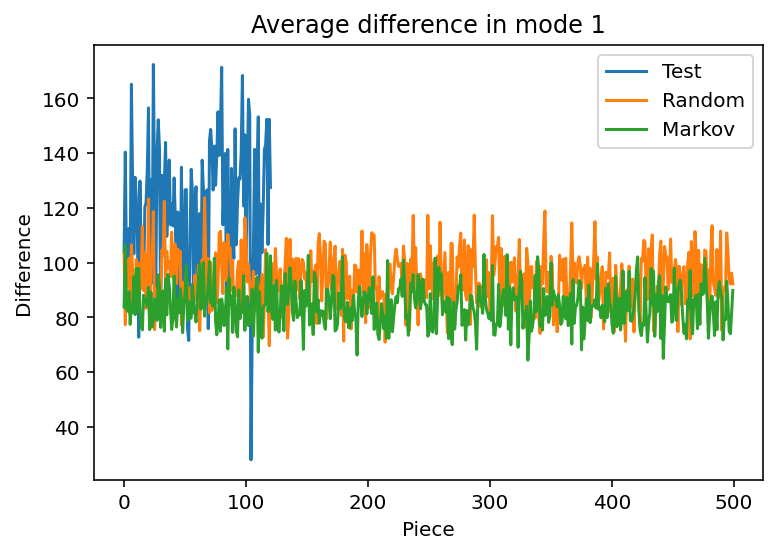

In [ ]:
plt.plot(range(len(distance_average_test_1)),distance_average_test_1,label="Test")
plt.plot(range(len(distance_average_random_1)),distance_average_random_1,label="Random")
plt.plot(range(len(distance_average_markov_1)),distance_average_markov_1,label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Average difference in mode 1")
plt.legend()

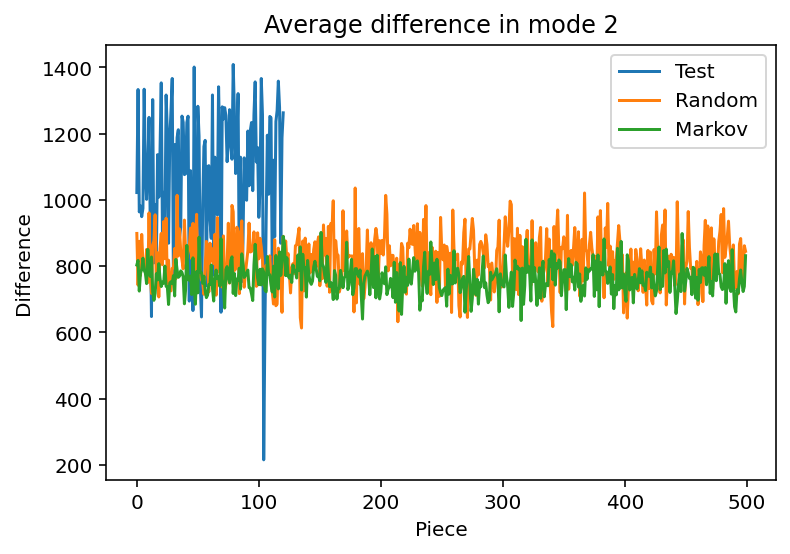

In [ ]:
plt.plot(range(len(distance_average_test_2)),distance_average_test_2,label="Test")
plt.plot(range(len(distance_average_random_2)),distance_average_random_2,label="Random")
plt.plot(range(len(distance_average_markov_2)),distance_average_markov_2,label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Average difference in mode 2")
plt.legend()

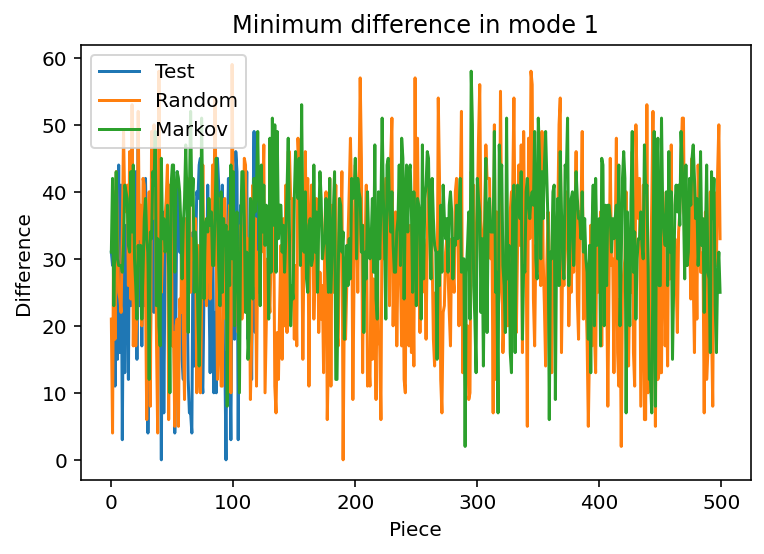

In [ ]:
plt.plot(range(len(re_test_1.min(axis=1))),re_test_1.min(axis=1),label="Test")
plt.plot(range(len(re_random_1.min(axis=1))),re_random_1.min(axis=1),label="Random")
plt.plot(range(len(re_markov_1.min(axis=1))),re_markov_1.min(axis=1),label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Minimum difference in mode 1")
plt.legend()

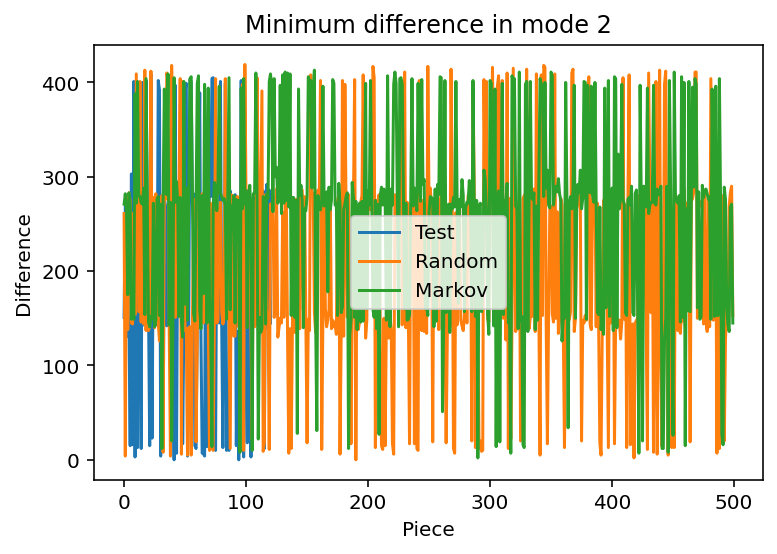

In [ ]:
plt.plot(range(len(re_test_2.min(axis=1))),re_test_2.min(axis=1),label="Test")
plt.plot(range(len(re_random_2.min(axis=1))),re_random_2.min(axis=1),label="Random")
plt.plot(range(len(re_markov_2.min(axis=1))),re_markov_2.min(axis=1),label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Minimum difference in mode 2")
plt.legend()